In [255]:
import torch
import torch.linalg as tla
import numpy as np
import matplotlib.pyplot as plt
import numml.sparse as sp
import numml.krylov
import scipy.sparse as scisp

In [256]:
# Use CUDA if it's available

# if torch.cuda.is_available():
#     device = torch.device('cuda:0')
# else:
#     device = torch.device('cpu')

# print(f'Using device {device}')
device = torch.device('cpu') # this problem is small enough that CPU is faster

In [257]:
# Create a 2D poisson operator

N_1D = 8
A_1D = sp.eye(N_1D)*2. - sp.eye(N_1D, k=1) - sp.eye(N_1D, k=-1)
#A_c = A.to(device)
A_sp = A_1D.to_scipy_csr()
A = sp.SparseCSRTensor(scisp.kron(A_sp, scisp.eye(N_1D)) + scisp.kron(scisp.eye(N_1D), A_sp))
A_c = A.to(device)
N = N_1D**2

In [258]:
A.shape

(64, 64)

In [259]:
# # linear forcing term, gives sinusoidal looking u

#b = torch.
#b_c = b.to(device)

b = torch.linspace(-1, 1, N_1D+2)[1:-1]
b = torch.meshgrid(b, b)[0].flatten()
b_c = b.to(device)

print(b.shape)

# plt.plot(b, label='rhs')
# plt.plot(sp.spsolve(A, b), label='true solution')
# plt.plot(numml.krylov.conjugate_gradient(A, b, iterations=15)[0], '--', label='CG soln')
# plt.legend()

torch.Size([64])


In [310]:
# Find some preconditioner w/ same sparsity as A
# optimize residual of last iterate wrt entries of M

#M = A.tril().to(device)
M = (sp.eye(N) * 2. + sp.eye(N,k=-1) * 0.1).to(device)
M.requires_grad = True

optimizer = torch.optim.AdamW([M.data], lr=0.001)
epochs = 100_000
lh = torch.zeros(epochs)
er = torch.zeros(epochs)
gamma = 0.7
training_it = 3
gamma_exp = (gamma ** (training_it - torch.arange(training_it + 1, device=device)))
gamma_exp /= tla.norm(gamma_exp, 1)
print('Gamma values', gamma_exp)

last_it = 0

for i in range(epochs):
    optimizer.zero_grad()
    last_it = i
    
    x_, res_ = numml.krylov.conjugate_gradient(A_c, b_c, iterations=training_it, M=(M@M.T))
    res_ /= tla.norm(b_c)
    loss = (gamma_exp[:len(res_)] * torch.log10(1. + res_)).sum()
    #loss = res_[-1]
    loss.backward()
    
    if torch.any(torch.isnan(res_)):
        print(loss, res_)
        break
    
    if res_[-1].detach().item() < 3e-5:
        lh[i] = loss.detach().item()
        er[i] = res_[-1].detach().item()
        print(f'{i:7g}', f'{loss.item():.3e}', f'{res_[-1].item():.3e}')
        break
    else:
        optimizer.step()
    lh[i] = loss.detach().item()
    er[i] = res_[-1].detach().item()
    
    if i % 100 == 0 or i == epochs - 1:
        print(f'{i:7g}', f'{loss.item():.3e}', f'{res_[-1].item():.3e}')

lh = lh[:last_it]
er = er[:last_it]

Gamma values tensor([0.1354, 0.1934, 0.2764, 0.3948])
      0 1.542e-01 1.727e-01
    100 1.127e-01 4.806e-02
    200 8.286e-02 1.824e-02
    300 7.468e-02 1.354e-02
    400 7.211e-02 9.935e-03
    500 7.064e-02 8.676e-03
    600 6.924e-02 8.337e-03
    700 6.758e-02 7.807e-03
    800 6.569e-02 7.390e-03
    900 6.357e-02 7.001e-03
   1000 6.115e-02 6.318e-03
   1100 5.844e-02 5.768e-03
   1200 5.530e-02 5.043e-03
   1300 5.156e-02 4.043e-03
   1400 4.707e-02 2.560e-03
   1500 4.172e-02 2.404e-04
   1546 4.080e-02 2.945e-05


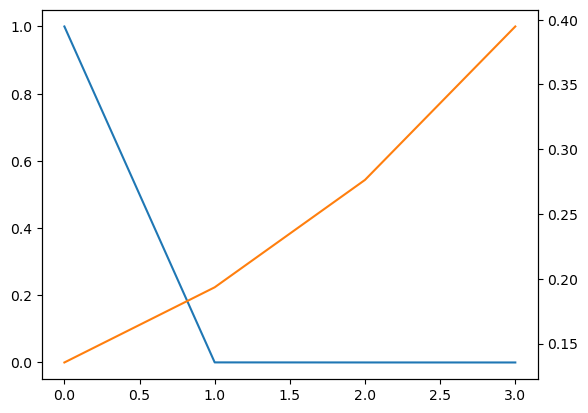

In [311]:
plt.plot(res_.detach())
ax2 = plt.gca().twinx()
ax2.plot(gamma_exp[:len(res_)], 'tab:orange')

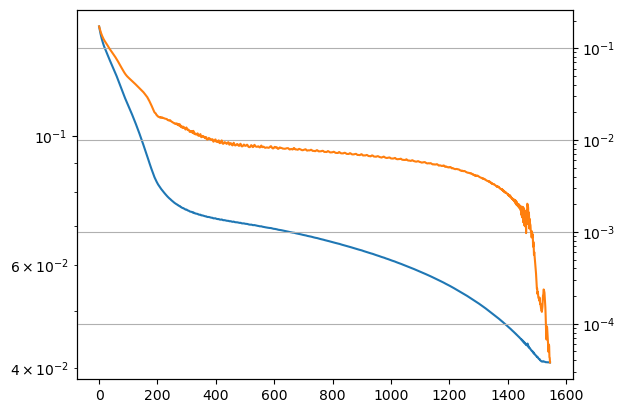

In [312]:
plt.semilogy(lh)
ax2 = plt.gca().twinx()
ax2.semilogy(er, 'tab:orange')
plt.grid()

In [317]:
x, res = numml.krylov.conjugate_gradient(A_c, b_c, iterations=12)
x_m, res_m = numml.krylov.conjugate_gradient(A_c, b_c, M=(M@M.T), iterations=N)

res = res.cpu() / tla.norm(b_c)
res_m = res_m.detach().cpu() / tla.norm(b_c)

/tmp/ipykernel_16333/310126745.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.semilogy(torch.tensor(res_m), label='Optimized PCG')


Text(0, 0.5, 'Residual')

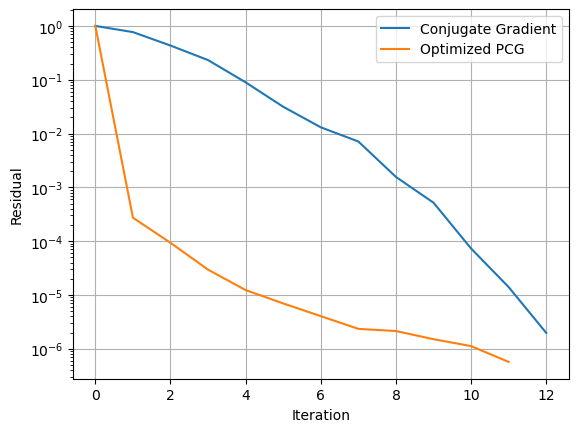

In [318]:
plt.semilogy(res, label='Conjugate Gradient')
plt.semilogy(torch.tensor(res_m), label='Optimized PCG')
plt.legend()
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Residual')